# <center> CS 178: Machine Learning &amp; Data Mining </center>
## <center>  Discussion: 25 May 2023 </center>

Let's start by importing some packages. We'll point out which of these imports we are using throughout the discussion, but it's handy to have them all in one place at the top of your notebook. This way, you can reload the imports without having to re-run everything else.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
     
from sklearn.datasets import fetch_openml, make_moons
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.preprocessing import PolynomialFeatures

import warnings
warnings.filterwarnings("ignore")

seed=1234
np.random.seed(seed)

# Subsampling Data

In [2]:
def subsample(X, y, subsample_size=None, num_features_to_keep=None):
    n, p = X.shape
    if subsample_size is None:
        subsample_size = n
    if num_features_to_keep is None:
        num_features_to_keep = p  # Keep all of them

    sample_indices = np.random.randint(low=0, high=n, size=(subsample_size,))
    feature_indices = np.random.choice(list(range(p)), size=(num_features_to_keep,), replace=False)
    
    X_sample, y_sample = X[sample_indices[:, np.newaxis], feature_indices], y[sample_indices]

    return X_sample, y_sample, feature_indices

In [3]:
class BaggingEnsemble:
    def __init__(self, base_estimator, n_estimators, subsample_size=None, num_features_to_keep=None, estimator_kwargs={}):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.subsample_size = subsample_size
        self.num_features_to_keep = num_features_to_keep
        self.estimator_kwargs = estimator_kwargs

        self.sub_models = []
        self.sub_features = []
        self.is_fit = False

    def fit(self, X, y):
        self.num_classes = len(np.unique(y))

        for _ in tqdm(range(self.n_estimators)):  # tqdm gives us a progress bar
            sub_model = self.base_estimator(**self.estimator_kwargs)
            X_sample, y_sample, feature_indices = subsample(X, y, subsample_size=self.subsample_size, num_features_to_keep=self.num_features_to_keep)
            sub_model.fit(X_sample, y_sample)
            self.sub_models.append(sub_model)
            self.sub_features.append(feature_indices)
        
        self.is_fit = True

    def predict(self, X):
        vote_counts = np.zeros((X.shape[0], self.num_classes))
        vote_indices = np.arange(X.shape[0])
        for sub_model, sub_features in tqdm(zip(self.sub_models, self.sub_features)):
            vote = sub_model.predict(X[:, sub_features])
            vote_counts[vote_indices, vote] += 1

        return np.argmax(vote_counts, axis=1)

    def predict_proba(self, X):
        dists = np.zeros((X.shape[0], self.num_classes))
        dist_indices = np.arange(X.shape[0])
        for sub_model, sub_features in tqdm(zip(self.sub_models, self.sub_features)):
            if hasattr(sub_model, 'predict_proba'):
                dist = sub_model.predict_proba(X[:, sub_features])
                dists += dist
            else:
                vote = sub_model.predict(X[:, sub_features])
                dists[dist_indices, vote] += 1

        dists = dists / dists.sum(axis=1, keepdims=True)  # Normalize so that each probability distribution sums to 1
        return dists
    
    def __sklearn_is_fitted__(self):  # Needed to interface with DecisionBoundaryDisplay
        return self.is_fit

### Bagged Ensembles on MNIST

First we will load in the MNIST data. This is a dataset of handwritten numerical digits (0, 1, 2, ..., 9) represented as 28x28 pixel images. The features will be the individual pixel values and the class labels are the corresponding digit that they are supposed to represent.

In [4]:
# Load the features and labels for the MNIST dataset
# This might take a minute to download the images.
mnist_X, mnist_y = fetch_openml('mnist_784', as_frame=False, return_X_y=True)

# Convert labels to integer data type
mnist_y = mnist_y.astype(int)

We will split this dataset into a train and test split, with 75% of the original data belonging to the training portion.

In [5]:
mnist_X_tr, mnist_X_te, mnist_y_tr, mnist_y_te = train_test_split(mnist_X, mnist_y, 
                                                                  test_size=0.25, random_state=seed, shuffle=True)

#### Plotting Images

The data comes preprocessed for us into a vector format for the features, so we will need to reshape it first to resemble a grid of pixels (i.e., an image). We can see the actual values by printing the array directly, or we can more naturally visualize it using the `.imshow()` method.

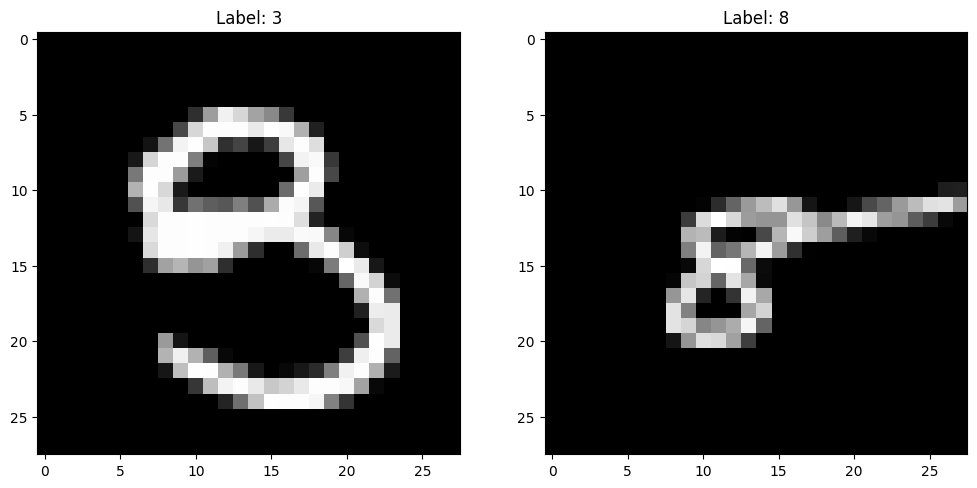

In [6]:
figure, axes = plt.subplots(1, 2, figsize=(12, 6))  

for i, ax in enumerate(axes):
    img = mnist_X_tr[i].reshape(28, 28)
    ax.imshow(img, cmap="gray")
    label = mnist_y_tr[i]
    ax.set_title(f'Label: {label}')

#### Prepocessing Images

Some of the base estimators we are using are sensitive to scale, so we want to standardize our inputs.

In [7]:
# Only compute scaling statistics on the training data!
X_mean, X_std = mnist_X_tr.mean(axis=0), mnist_X_tr.std(axis=0)
X_tr = (mnist_X_tr - X_mean) / (X_std + 1e-4)
X_te = (mnist_X_te - X_mean) / (X_std + 1e-4)  # We need to transform the test data as well!

## Ensemble w/ Nearest Centroid

In [8]:
# Performance with basic Nearest Centroid
single_model = NearestCentroid()
single_model.fit(X_tr, mnist_y_tr)
y_pred = single_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

0.8044571428571429

In [9]:
ensemble_model = BaggingEnsemble(
    base_estimator=NearestCentroid, 
    n_estimators=20, 
    subsample_size=None, # Full size subsamples w/ replacement
    num_features_to_keep=None, # Keep all features
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 20/20 [00:05<00:00,  3.98it/s]
20it [00:03,  6.03it/s]


0.8049714285714286

In [10]:
ensemble_model = BaggingEnsemble(
    base_estimator=NearestCentroid, 
    n_estimators=20, 
    subsample_size=1000,
    num_features_to_keep=None, # Keep all features
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 20/20 [00:00<00:00, 252.41it/s]
20it [00:03,  6.05it/s]


0.8016571428571428

In [11]:
ensemble_model = BaggingEnsemble(
    base_estimator=NearestCentroid, 
    n_estimators=100, 
    subsample_size=1000, 
    num_features_to_keep=100,
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 100/100 [00:00<00:00, 407.14it/s]
100it [00:02, 41.06it/s]


0.7953714285714286

We don't see too much improvement when ensembling nearest centroid, but let's see if that is the case with logistic regression.

## Ensemble w/ Logistic Regression

In [12]:
# Performance with Logistic Regression
single_model = LogisticRegression()
single_model.fit(X_tr, mnist_y_tr)
y_pred = single_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

0.9149142857142857

In [13]:
ensemble_model = BaggingEnsemble(
    base_estimator=LogisticRegression, 
    n_estimators=20, 
    subsample_size=None, 
    num_features_to_keep=None,
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 20/20 [01:07<00:00,  3.40s/it]
20it [00:03,  5.48it/s]


0.9150857142857143

In [14]:
ensemble_model = BaggingEnsemble(
    base_estimator=LogisticRegression, 
    n_estimators=100, 
    subsample_size=1000, 
    num_features_to_keep=100,
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 100/100 [00:08<00:00, 11.45it/s]
100it [00:02, 48.64it/s]


0.9036571428571428

In [15]:
ensemble_model = BaggingEnsemble(
    base_estimator=LogisticRegression, 
    n_estimators=1000, 
    subsample_size=1000, 
    num_features_to_keep=20,
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 1000/1000 [00:52<00:00, 18.92it/s]
1000it [00:05, 175.04it/s]


0.8023428571428571

Similar story to before, just naively ensembling doesn't seem to improve logistic regression much. We haven't explored all the different hyperparameters for logistic regression though, so it is possible that there is some setting in which this would improve the results. We will leave that to you to explore on your own. Let's look at how ensembling helps decision trees.

## Ensemble w/ Decision Tree

In [16]:
# Performance with Decision Tree
single_model = DecisionTreeClassifier()
single_model.fit(X_tr, mnist_y_tr)
y_pred = single_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

0.8652571428571428

In [17]:
ensemble_model = BaggingEnsemble(
    base_estimator=DecisionTreeClassifier, 
    n_estimators=20, 
    subsample_size=None, 
    num_features_to_keep=None,
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 20/20 [03:18<00:00,  9.94s/it]
20it [00:03,  5.51it/s]


0.9494285714285714

In [18]:
ensemble_model = BaggingEnsemble(
    base_estimator=DecisionTreeClassifier, 
    n_estimators=100, 
    subsample_size=None, 
    num_features_to_keep=100,
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]
100it [00:02, 43.66it/s]


0.9646857142857143

In [19]:
ensemble_model = BaggingEnsemble(
    base_estimator=DecisionTreeClassifier, 
    n_estimators=100, 
    subsample_size=1000, 
    num_features_to_keep=100,
    estimator_kwargs={},
)

ensemble_model.fit(X_tr, mnist_y_tr)
y_pred = ensemble_model.predict(X_te)
accuracy_score(mnist_y_te, y_pred)

100%|██████████| 100/100 [00:01<00:00, 73.71it/s]
100it [00:02, 47.30it/s]


0.9213142857142858

# Visualize Decision Boundaries

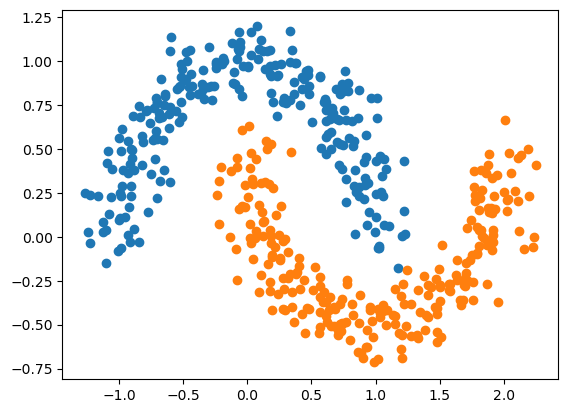

In [35]:
X, y = make_moons(500, noise=0.12)
plt.scatter(X[y==0, 0], X[y==0, 1], c='tab:blue')
plt.scatter(X[y==1, 0], X[y==1, 1], c='tab:orange')

In [39]:
def plot_decision_boundary(model):
    disp = DecisionBoundaryDisplay.from_estimator(
        model,
        X,
        grid_resolution=100,
        plot_method="pcolormesh",
        response_method="predict_proba" if hasattr(model, "predict_proba") else "predict",
        alpha=0.5,
    )
    disp.ax_.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")

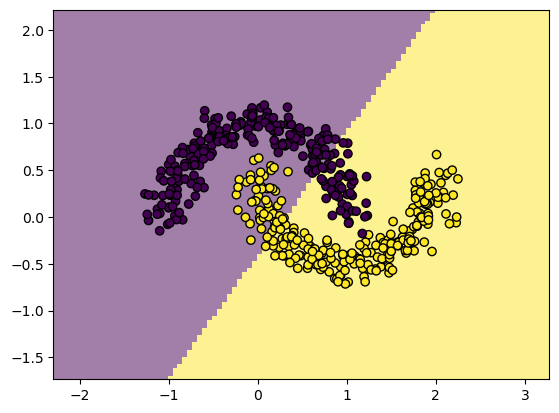

In [40]:
single_model = NearestCentroid()
single_model.fit(X, y)

plot_decision_boundary(single_model)

100%|██████████| 100/100 [00:00<00:00, 1676.25it/s]
100it [00:00, 1129.73it/s]


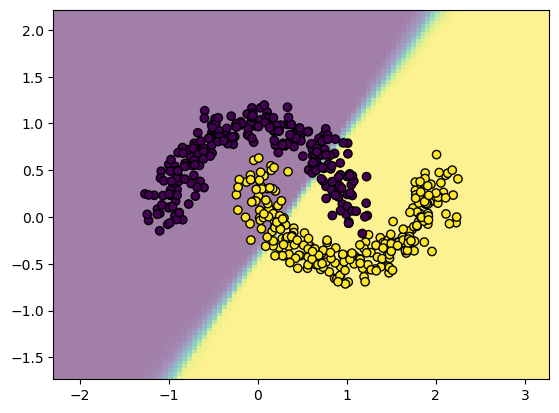

In [50]:
ensemble_model = BaggingEnsemble(
    base_estimator=NearestCentroid, 
    n_estimators=100, 
    subsample_size=None, # Full size subsamples w/ replacement
    num_features_to_keep=None, # Keep all features
    estimator_kwargs={},
)
ensemble_model.fit(X, y)
plot_decision_boundary(ensemble_model)

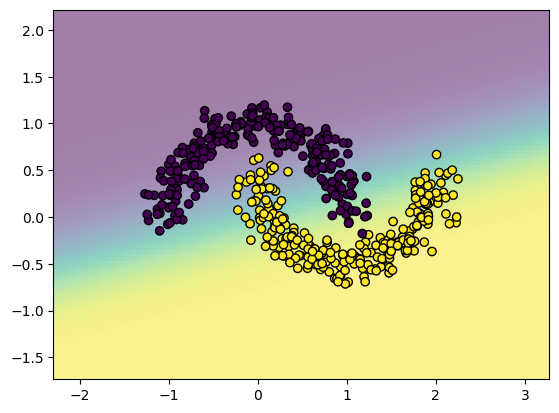

In [46]:
single_model = LogisticRegression()
single_model.fit(X, y)

plot_decision_boundary(single_model)

100%|██████████| 100/100 [00:00<00:00, 420.42it/s]
100it [00:00, 2692.82it/s]


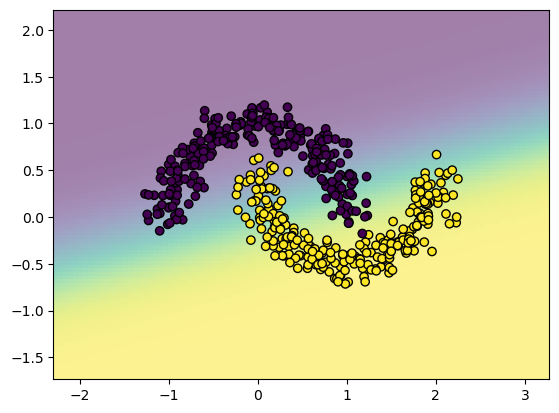

In [51]:
ensemble_model = BaggingEnsemble(
    base_estimator=LogisticRegression, 
    n_estimators=100, 
    subsample_size=None, # Full size subsamples w/ replacement
    num_features_to_keep=None, # Keep all features
    estimator_kwargs={},
)
ensemble_model.fit(X, y)
plot_decision_boundary(ensemble_model)

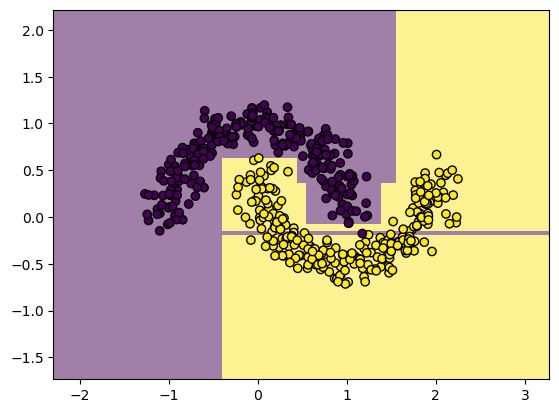

In [58]:
single_model = DecisionTreeClassifier()
single_model.fit(X, y)

plot_decision_boundary(single_model)

100%|██████████| 1000/1000 [00:00<00:00, 1136.11it/s]
1000it [00:00, 2459.36it/s]


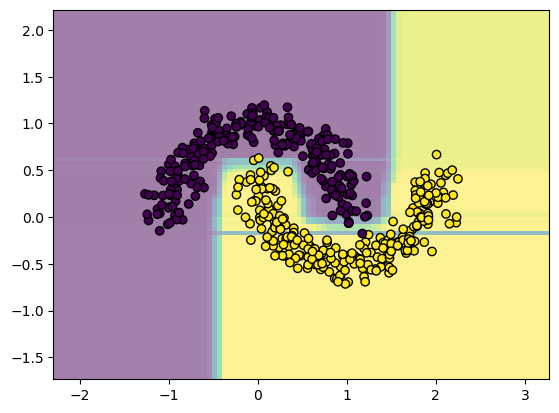

In [59]:
ensemble_model = BaggingEnsemble(
    base_estimator=DecisionTreeClassifier, 
    n_estimators=1000, 
    subsample_size=None, # Full size subsamples w/ replacement
    num_features_to_keep=None, # Keep all features
    estimator_kwargs={},
)
ensemble_model.fit(X, y)
plot_decision_boundary(ensemble_model)

100%|██████████| 1000/1000 [00:00<00:00, 1573.97it/s]
1000it [00:00, 2494.49it/s]


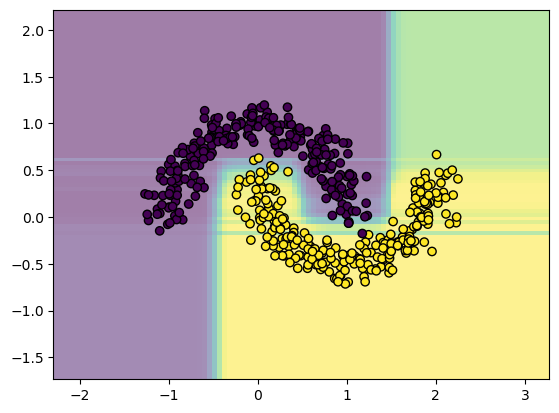

In [60]:
ensemble_model = BaggingEnsemble(
    base_estimator=DecisionTreeClassifier, 
    n_estimators=1000, 
    subsample_size=200, # Full size subsamples w/ replacement
    num_features_to_keep=None, # Keep all features
    estimator_kwargs={},
)
ensemble_model.fit(X, y)
plot_decision_boundary(ensemble_model)

100%|██████████| 1000/1000 [00:00<00:00, 1897.05it/s]
1000it [00:00, 2587.82it/s]


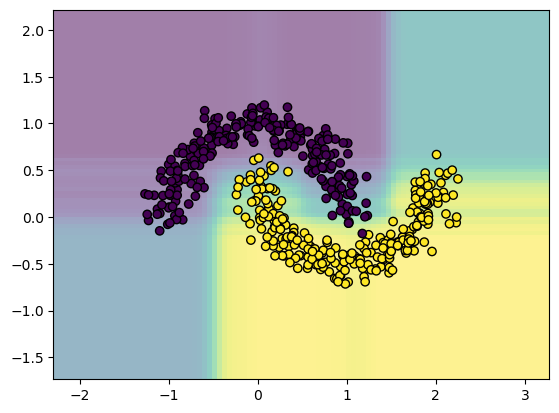

In [61]:
ensemble_model = BaggingEnsemble(
    base_estimator=DecisionTreeClassifier, 
    n_estimators=1000, 
    subsample_size=50, # Full size subsamples w/ replacement
    num_features_to_keep=None, # Keep all features
    estimator_kwargs={},
)
ensemble_model.fit(X, y)
plot_decision_boundary(ensemble_model)